In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `C:\Users\tge13\Documents\optimal_control_julia\lec_12\Project.toml`


In [2]:
using LinearAlgebra
using Plots
using ForwardDiff
using RobotZoo
const RZ = RobotZoo
using RobotDynamics
using Ipopt
using MathOptInterface
using JLD2
const MOI = MathOptInterface;

In [3]:
#Pendulum Dynamics
a = RobotZoo.Acrobot()
h = 0.1 #10 Hz

0.1

In [4]:
Nx = 4     # number of state
Nu = 1     # number of controls
Tfinal = 5.0 # final time
Nt = Int(Tfinal/h)+1   # number of time steps
thist = Array(range(0,h*(Nt-1), step=h));

n_nlp = (Nx+Nu)*Nt # number of decision variables
m_nlp = Nx*(Nt+1)

208

## DIRCOL Residual

In [5]:
function dircol_dynamics(x1,u1,x2,u2)
    #Hermite-Simpson integration with first-order hold on u
    f1 = RZ.dynamics(a, x1, u1)
    f2 = RZ.dynamics(a, x2, u2)
    xm = 0.5*(x1+x2) + (h/8.0)*(f1-f2)
    um = 0.5*(u1+u2)
    fm = RZ.dynamics(a, xm, um)
    ẋm = (3/(2.0*h))*(x1-x2) + (0.25)*(f1+f2)
    return fm + ẋm
end

dircol_dynamics (generic function with 1 method)

In [6]:
# Cost weights
Q = Diagonal([1.0*ones(2); 1.0*ones(2)]);
R = 0.1;

In [7]:
function cost(ztraj)
    J = 0
    z_reshape = reshape(ztraj, Nx+Nu, Nt)
    for k in 1:Nt
        xtraj = z_reshape[1:Nx,k]
        utraj = z_reshape[Nx+1:end,k]
        J += 0.5*(xtraj-xgoal)'*Q*(xtraj-xgoal) + 0.5*utraj'*R*utraj
    end

    return J
end

cost (generic function with 1 method)

## Fill in dynamics constriants

In [8]:
function dynamics_constraint!(c,ztraj)
    d = reshape(c, Nx, Nt-1)
    z = reshape(ztraj, Nx+Nu, Nt)

    for k in 1:(Nt-1)
        x1 = z[1:Nx,k]
        u1 = z[Nx+1:end,k]
        x2 = z[1:Nx,k+1]
        u2 = z[Nx+1:end,k+1]

        d[:,k] = dircol_dynamics(x1,u1,x2,u2)
    end

    return nothing
end

dynamics_constraint! (generic function with 1 method)

In [9]:
function con!(c,ztraj)
    z = reshape(ztraj, Nx+Nu, Nt)
    c[1:Nx, 1] .= (z[1:Nx,1] - x0)
    @views dynamics_constraint!(c[(Nx+1):(end-Nx)],ztraj)
    c[(end-Nx+1):end] .= (z[1:Nx,end] - xgoal)
end

con! (generic function with 1 method)

## Define Variables & Constraints - ProbMOI and IPOPT Format

In [10]:
struct ProblemMOI <: MOI.AbstractNLPEvaluator
    n_nlp::Int
    m_nlp::Int
    idx_ineq
    obj_grad::Bool
    con_jac::Bool
    sparsity_jac
    sparsity_hess
    primal_bounds
    constraint_bounds
    hessian_lagrangian::Bool
end

function ProblemMOI(n_nlp,m_nlp;
        idx_ineq=(1:0),
        obj_grad=true,
        con_jac=true,
        sparsity_jac=sparsity_jacobian(n_nlp,m_nlp),
        sparsity_hess=sparsity_hessian(n_nlp,m_nlp),
        primal_bounds=primal_bounds(n_nlp),
        constraint_bounds=constraint_bounds(m_nlp,idx_ineq=idx_ineq),
        hessian_lagrangian=false)

    ProblemMOI(n_nlp,m_nlp,
        idx_ineq,
        obj_grad,
        con_jac,
        sparsity_jac,
        sparsity_hess,
        primal_bounds,
        constraint_bounds,
        hessian_lagrangian)
end

function primal_bounds(n)
    x_l = -Inf*ones(n)
    x_u = Inf*ones(n)
    return x_l, x_u
end

function constraint_bounds(m; idx_ineq=(1:0))
    c_l = zeros(m)
    c_l[idx_ineq] .= -Inf

    c_u = zeros(m)
    return c_l, c_u
end

function row_col!(row,col,r,c)
    for cc in c
        for rr in r
            push!(row,convert(Int,rr))
            push!(col,convert(Int,cc))
        end
    end
    return row, col
end

function sparsity_jacobian(n,m)

    row = []
    col = []

    r = 1:m
    c = 1:n

    row_col!(row,col,r,c)

    return collect(zip(row,col))
end

function sparsity_hessian(n,m)

    row = []
    col = []

    r = 1:m
    c = 1:n

    row_col!(row,col,r,c)

    return collect(zip(row,col))
end

function MOI.eval_objective(prob::MOI.AbstractNLPEvaluator, x)
    cost(x)
end

function MOI.eval_objective_gradient(prob::MOI.AbstractNLPEvaluator, grad_f, x)
    ForwardDiff.gradient!(grad_f,cost,x)
    return nothing
end

function MOI.eval_constraint(prob::MOI.AbstractNLPEvaluator,g,x)
    con!(g,x)
    return nothing
end

function MOI.eval_constraint_jacobian(prob::MOI.AbstractNLPEvaluator, jac, x)
    ForwardDiff.jacobian!(reshape(jac,prob.m_nlp,prob.n_nlp), con!, zeros(prob.m_nlp), x)
    return nothing
end

function MOI.features_available(prob::MOI.AbstractNLPEvaluator)
    return [:Grad, :Jac]
end

MOI.initialize(prob::MOI.AbstractNLPEvaluator, features) = nothing
MOI.jacobian_structure(prob::MOI.AbstractNLPEvaluator) = prob.sparsity_jac

function solve(x0,prob::MOI.AbstractNLPEvaluator;
        tol=1.0e-6,c_tol=1.0e-6,max_iter=10000)
    x_l, x_u = prob.primal_bounds
    c_l, c_u = prob.constraint_bounds

    nlp_bounds = MOI.NLPBoundsPair.(c_l,c_u)
    block_data = MOI.NLPBlockData(nlp_bounds,prob,true)

    solver = Ipopt.Optimizer()
    solver.options["max_iter"] = max_iter
    solver.options["tol"] = tol
    solver.options["constr_viol_tol"] = c_tol

    x = MOI.add_variables(solver,prob.n_nlp)

    for i = 1:prob.n_nlp
        MOI.add_constraint(solver, x[i], MOI.LessThan(x_u[i]))
        MOI.add_constraint(solver, x[i], MOI.GreaterThan(x_l[i]))
        MOI.set(solver, MOI.VariablePrimalStart(), x[i], x0[i])
    end

    # Solve the problem
    MOI.set(solver, MOI.NLPBlock(), block_data)
    MOI.set(solver, MOI.ObjectiveSense(), MOI.MIN_SENSE)
    MOI.optimize!(solver)

    # Get the solution
    res = MOI.get(solver, MOI.VariablePrimal(), x)

    return res
end

solve (generic function with 1 method)

In [11]:
#Initial and goal states
x0 = [-pi/2; 0; 0; 0]
xgoal = [pi/2; 0; 0; 0]

4-element Vector{Float64}:
 1.5707963267948966
 0.0
 0.0
 0.0

## Load Pre-trained trajectories

In [12]:
f = jldopen("dircol_traj.jld2", "r")
xtraj_opt = f["xtraj"]
utraj_opt = f["utraj"]

1×51 Matrix{Float64}:
 0.127166  0.598139  1.02962  1.38087  1.66891  …  0.297042  2.13363  1.93323

## Case1 - Fully Random Initial Guess

In [13]:
xguess = kron(ones(Nt)', x0)
uguess = zeros(Nt)'
z0 = reshape([xguess; uguess], Nx+Nu, Nt)

5×51 Matrix{Float64}:
 -1.5708  -1.5708  -1.5708  -1.5708  …  -1.5708  -1.5708  -1.5708  -1.5708
  0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0
  0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0
  0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0
  0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0

In [17]:
prob = ProblemMOI(n_nlp,m_nlp)

# solve
z_sol = solve(z0,prob)

# reshape
ztraj = reshape(z_sol,Nx+Nu,Nt)
xtraj = ztraj[1:Nx,:]
utraj = ztraj[(Nx+1):(Nx+Nu),:];


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    53040
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      255
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equal

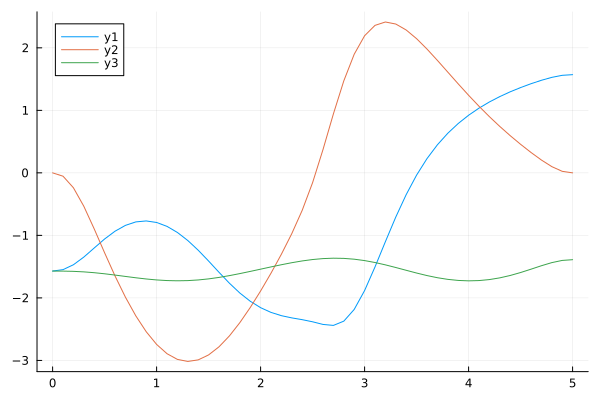

In [18]:
plot(thist,xtraj[1,:], label=["θ₁"])
plot!(thist,xguess[1,:], label=["θ₁ guess"])
plot!(thist,xtraj[2,:], label=["ω₁"])

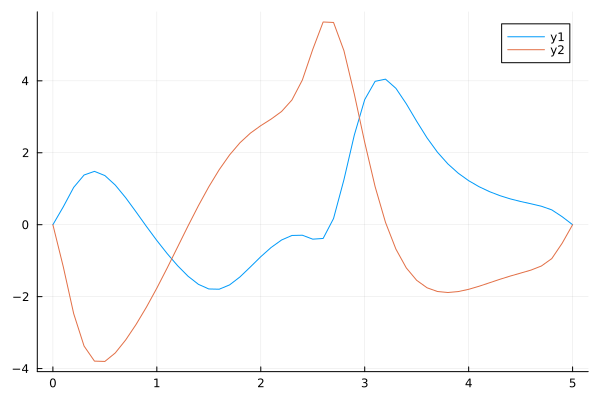

In [19]:
plot(thist,xtraj[3,:])
plot!(thist,xtraj[4,:])

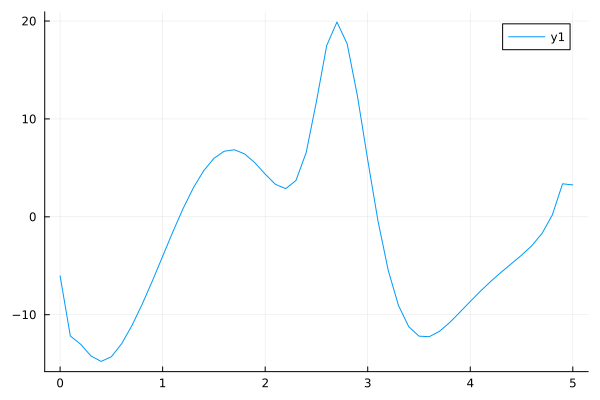

In [20]:
plot(thist,utraj[1,:])

In [21]:
using TrajOptPlots
using MeshCat
using StaticArrays

vis = Visualizer()
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8700


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), Set{Any}(), ip"127.0.0.1", 8700))

In [22]:
TrajOptPlots.set_mesh!(vis, a)

MeshCat Visualizer with path /meshcat/robot/link1/joint at http://127.0.0.1:8700

In [23]:
X1 = [SVector{4}(x) for x in eachcol(xtraj)];
visualize!(vis, a, thist[end], X1)

## Case2 - Warm Start with Pre-trained Traj + Noise

In [14]:
xguess = kron(ones(Nt)', x0)
xguess[1,:] .= xtraj_opt[1,:] + 0.1*randn(Nt)
z0 = reshape([xguess; uguess], Nx+Nu, Nt)

5×51 Matrix{Float64}:
 -1.75573  -1.66394  -1.55227  -1.57471  …  -1.41021  -1.35497  -1.50593
  0.0       0.0       0.0       0.0          0.0       0.0       0.0
  0.0       0.0       0.0       0.0          0.0       0.0       0.0
  0.0       0.0       0.0       0.0          0.0       0.0       0.0
  0.0       0.0       0.0       0.0          0.0       0.0       0.0

In [15]:
prob = ProblemMOI(n_nlp,m_nlp)

# solve
z_sol = solve(z0,prob)

# reshape
ztraj = reshape(z_sol,Nx+Nu,Nt)
xtraj = ztraj[1:Nx,:]
utraj = ztraj[(Nx+1):(Nx+Nu),:];


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    53040
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      255
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equal

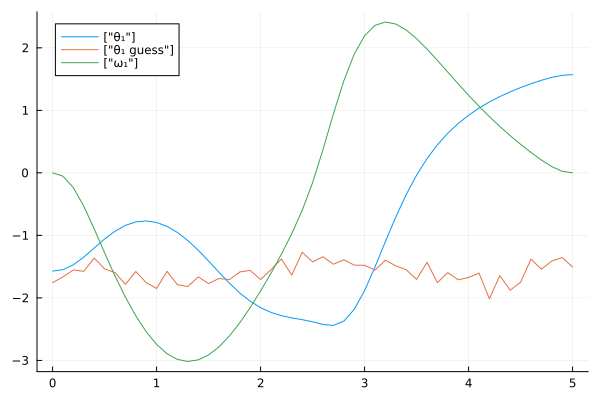

In [28]:
plot(thist,xtraj[1,:], label=["θ₁"])
plot!(thist,xguess[1,:], label=["θ₁ guess"])
plot!(thist,xtraj[2,:], label=["ω₁"])

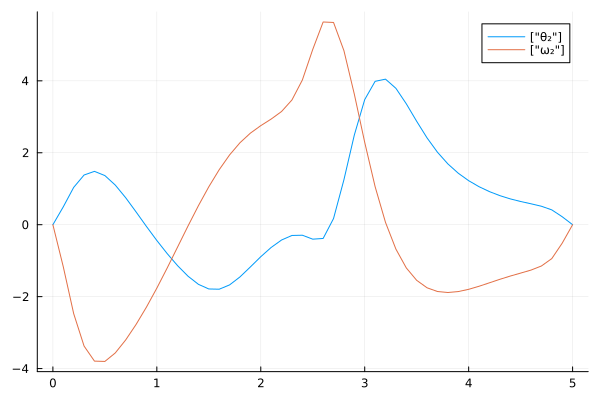

In [29]:
plot(thist,xtraj[3,:], label=["θ₂"])
plot!(thist,xtraj[4,:], label=["ω₂"])

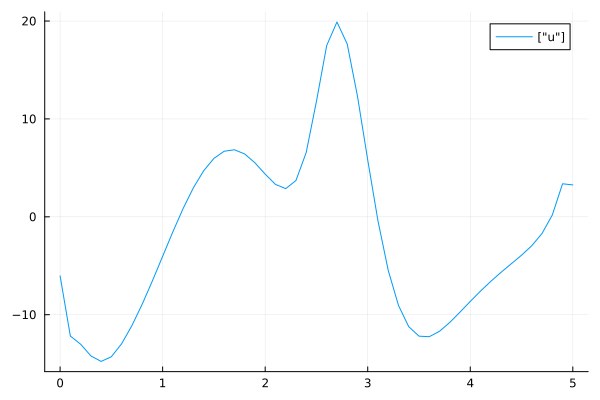

In [30]:
plot(thist,utraj[1,:], label=["u"])

In [19]:
using TrajOptPlots
using MeshCat
using StaticArrays

vis = Visualizer()
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8700


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), Set{Any}(), ip"127.0.0.1", 8700))

In [20]:
TrajOptPlots.set_mesh!(vis, a)

MeshCat Visualizer with path /meshcat/robot/link1/joint at http://127.0.0.1:8700

In [21]:
X1 = [SVector{4}(x) for x in eachcol(xtraj)];
visualize!(vis, a, thist[end], X1)